# Sentiment analysis and classification App Store reviews

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


from tqdm import tqdm

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from transformers import pipeline

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

from textblob import TextBlob




[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aleks\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aleks\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# Load df
df = pd.read_csv(
    "C:/bootcamp/capstone_chat-gpt/data/apple_short_clean.csv",
    encoding="utf-8",
)

## Zero-shot-classification

In [5]:
classifier = pipeline("zero-shot-classification")

No model was supplied, defaulted to roberta-large-mnli and revision 130fb28 (https://huggingface.co/roberta-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [6]:
#candidate_labels = ["feature evaluation", "praise", "bug report", "feature request", "performance", "usage"]
candidate_labels = ["positive", "neutral", "negative"]
hypothesis_template = "The sentiment of this review is {}."

In [7]:
#candidate_labels = list(category_map.values())
predictedCategories = []
ScoreNegative = []
ScoreNeutral = []
ScorePositive = []

for i in tqdm(range(len(df))): # len(df)
    text = df.iloc[i,]['review']
    res = classifier(text, candidate_labels, hypothesis_template=hypothesis_template, multi_label=True)
    labels = res['labels'] 
    scores = res['scores'] #extracting the scores associated with the labels
    res_dict = {label : score for label,score in zip(labels, scores)}
    sorted_dict = dict(sorted(res_dict.items(), key=lambda x:x[1],reverse = True)) #sorting the dictionary of labels in descending order based on their score
    categories  = next(k for i, (k,v) in enumerate(sorted_dict.items()))

    ScorePositive.append(sorted_dict['positive'])
    ScoreNeutral.append(sorted_dict['neutral'])
    ScoreNegative.append(sorted_dict['negative'])
    predictedCategories.append(categories)

100%|██████████| 3368/3368 [1:41:01<00:00,  1.80s/it]  


In [8]:
df_zero_prep = pd.DataFrame({  'category': predictedCategories, 
                                    'positive_score': ScorePositive, 
                                    'neutral_score': ScoreNeutral, 
                                    'negative_score': ScoreNegative})
df_zero = pd.merge(df, df_zero_prep, left_index=True, right_index=True)

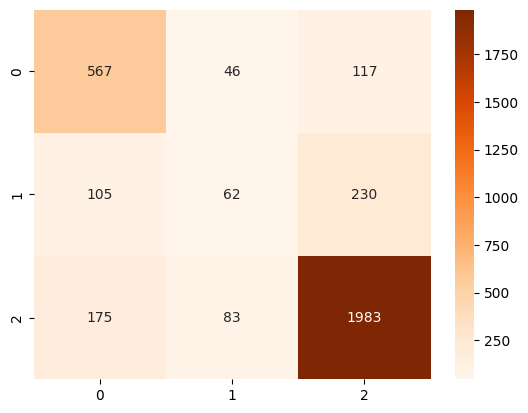

In [9]:
#Confusion matrix using pandas crosstab
conf_matrix = confusion_matrix(df_zero.score_cat, df_zero.category)
sns.heatmap(conf_matrix, annot=True, cmap=plt.cm.Oranges, fmt='g'); 

In [10]:
df_zero.to_csv("C:/bootcamp/capstone_chat-gpt/data/app-reviews-zero.csv", index=False)

## VADER (Valence Aware Dictionary for Sentiment Reasoning)

In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    #note: depending on how you installed (e.g., using source code download versus pip install), you may need to import like this:
    #from vaderSentiment import SentimentIntensityAnalyzer

In [37]:
from nltk import tokenize

#candidate_labels = list(category_map.values())
vad_cat = []
vad_neg = []
vad_neu = []
vad_pos = []

for sentence in tqdm(df['review']):
     sid = SentimentIntensityAnalyzer()
     ss = sid.polarity_scores(sentence)
     for k in sorted(ss):
         vad_cat.append(max(ss, key=ss.get))
         vad_neg.append(ss['neg'])
         vad_neu.append(ss['neu'])
         vad_pos.append(ss['pos'])

100%|██████████| 3368/3368 [00:23<00:00, 145.57it/s]


In [38]:
df_vader_prep = pd.DataFrame({ 'vader_cat': vad_cat, 
                                'vader_neg': vad_neg, 
                                'vader_neu': vad_neu, 
                                'vader_pos': vad_pos})
df_vader= pd.merge(df_zero, df_vader_prep, left_index=True, right_index=True)

In [39]:
df_vader.to_csv("C:/bootcamp/capstone_chat-gpt/data/app_reviews_zero_vader.csv", index=False)

## Sentiment Analysis using TextBlob

In [16]:
#candidate_labels = list(category_map.values())
blob_polarity = []
blob_subjectivity = []

for sentence in tqdm(df['review']):
     blob_polarity.append(TextBlob(sentence).sentiment.polarity)
     blob_subjectivity.append(TextBlob(sentence).sentiment.subjectivity)

100%|██████████| 3368/3368 [00:01<00:00, 2670.36it/s]


In [17]:
df_blob_prep = pd.DataFrame({ 'blob_polarity': blob_polarity, 
                                    'blob_subjectivity': blob_subjectivity})
df_blob= pd.merge(df_vader, df_blob_prep, left_index=True, right_index=True)

In [40]:
df_blob.to_csv("C:/bootcamp/capstone_chat-gpt/data/zero_vader_blob_apple_sentiment.csv", index=False)

## Sentiment Analysis using Transformer-Based Models

In [25]:
from transformers import pipeline

# Указание модели и ревизии
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)


All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [30]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")

pipe_cat = []
pipe_neg = []
pipe_pos = []

for sentence in tqdm(df['review']):
    try:
        res = sentiment_pipeline(sentence)
        if res[0]['label'] == 'POSITIVE':
            pipe_cat.append('POSITIVE')
            pipe_neg.append(1 - res[0]['score'])
            pipe_pos.append(res[0]['score'])
        elif res[0]['label'] == 'NEGATIVE':
            pipe_cat.append('NEGATIVE')
            pipe_neg.append(res[0]['score'])
            pipe_pos.append(1 - res[0]['score'])
    except Exception as e:
        print(f"Error processing sentence: {str(e)}")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
 46%|████▋     | 1558/3368 [04:00<03:28,  8.68it/s]

Error processing sentence: Exception encountered when calling layer 'embeddings' (type TFEmbeddings).

{{function_node __wrapped__ResourceGather_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[0,660] = 660 is not in [0, 512) [Op:ResourceGather]

Call arguments received by layer 'embeddings' (type TFEmbeddings):
  • input_ids=tf.Tensor(shape=(1, 675), dtype=int32)
  • position_ids=None
  • inputs_embeds=None
  • training=False


 61%|██████    | 2057/3368 [05:06<02:19,  9.39it/s]

Error processing sentence: Exception encountered when calling layer 'embeddings' (type TFEmbeddings).

{{function_node __wrapped__ResourceGather_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[0,512] = 512 is not in [0, 512) [Op:ResourceGather]

Call arguments received by layer 'embeddings' (type TFEmbeddings):
  • input_ids=tf.Tensor(shape=(1, 719), dtype=int32)
  • position_ids=None
  • inputs_embeds=None
  • training=False


 69%|██████▉   | 2316/3368 [05:43<02:55,  5.98it/s]

Error processing sentence: Exception encountered when calling layer 'embeddings' (type TFEmbeddings).

{{function_node __wrapped__ResourceGather_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[0,512] = 512 is not in [0, 512) [Op:ResourceGather]

Call arguments received by layer 'embeddings' (type TFEmbeddings):
  • input_ids=tf.Tensor(shape=(1, 827), dtype=int32)
  • position_ids=None
  • inputs_embeds=None
  • training=False


100%|██████████| 3368/3368 [07:57<00:00,  7.06it/s]


In [31]:
df_pipe_prep = pd.DataFrame({ 'pipe_cat': pipe_cat, 
                                    'pipe_neg': pipe_neg, 
                                    'pipe_pos': pipe_pos})

In [41]:
df_pipe= pd.merge(df_blob, df_pipe_prep, left_index=True, right_index=True)

In [42]:
df_pipe.to_csv("C:/bootcamp/capstone_chat-gpt/data/app_reviews_sentiment.csv", index=False)



In [43]:
df_pipe.head()

,Unnamed: 0,date,review,rating,userName,title,country,at_ymd,at_q,at_ym,...,negative_score,vader_cat,vader_neg,vader_neu,vader_pos,blob_polarity,blob_subjectivity,pipe_cat,pipe_neg,pipe_pos
0,0,2023-09-12 19:05:19,very much love the app way better than google ...,5.0,Tj77883344,"Love it, been using it since last year",us,09/12/23,3,2023-09,...,0.001946,compound,0.020,0.858,0.123,0.154762,0.433962,POSITIVE,0.279342,0.720658
1,1,2023-09-10 02:45:51,up to this point i've mostly been using chatgp...,4.0,PDXJavaJunkie,Much more accessible for blind users than the ...,us,09/10/23,3,2023-09,...,0.023911,compound,0.020,0.858,0.123,0.215385,0.581731,NEGATIVE,0.915617,0.084383
2,2,2023-07-11 12:24:19,i've been a user since it's initial roll out a...,4.0,Tinny tower addicted,"Much anticipated, wasn’t let down.",us,07/11/23,3,2023-07,...,0.004290,compound,0.020,0.858,0.123,0.225992,0.566501,NEGATIVE,0.916687,0.083313
3,3,2023-05-27 21:57:27,i recently downloaded the app and overall it's...,4.0,Would Po,"4.5 stars, here’s why",us,05/27/23,2,2023-05,...,0.015336,compound,0.020,0.858,0.123,0.275429,0.561762,POSITIVE,0.064406,0.935594
4,4,2023-09-20 15:54:11,oh my gosh i cannot explain how much i've use ...,5.0,MORE FREE PAINTINGS!!!,Always quick!,us,09/20/23,3,2023-09,...,0.003096,compound,0.051,0.750,0.199,0.214705,0.682914,POSITIVE,0.002602,0.997398
